The gain/loss module shows the increase or decrease of a product or category's sales or customer account between two 
time periods. It is anaylzes the shift in a KPI based on,
* New vs lost buyers
* Increased vs decreased spending
* Switching between the focus group and a comparison group

A typical use case is to analyze promotion cannibalization, which we will explore below.

### Setup

We'll start by loading some simulated data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_parquet("../../data/transactions.parquet")
df.head()

,transaction_id,transaction_date,transaction_time,customer_id,product_id,product_name,category_0_name,category_0_id,category_1_name,category_1_id,brand_name,brand_id,unit_quantity,unit_cost,unit_spend,store_id
0,16050,2023-01-12,17:44:29,1,15,Spawn Figure,Toys,1,Action Figures,1,McFarlane Toys,3,2,36.10,55.98,6
1,16050,2023-01-12,17:44:29,1,1317,Gone Girl,Books,8,Mystery & Thrillers,53,Alfred A. Knopf,264,1,6.98,10.49,6
2,20090,2023-02-05,09:31:42,1,509,Ryzen 3 3300X,Electronics,3,Computer Components,21,AMD,102,3,200.61,360.00,4
3,20090,2023-02-05,09:31:42,1,735,Linden Wood Paneled Mirror,Home,5,Home Decor,30,Pottery Barn,147,1,379.83,599.00,4
4,20090,2023-02-05,09:31:42,1,1107,Pro-V Daily Moisture Renewal Conditioner,Beauty,7,Hair Care,45,Pantene,222,1,3.32,4.99,4


In [ ]:
print(f"Number of unique customers: {df['customer_id'].nunique()}")
print(f"Number of unique transactions: {df['transaction_id'].nunique()}")

Number of unique customers: 4250
Number of unique transactions: 25490


## Scenario: Calvin Klein Promotion Cannibalization

You work for a large department store and last year you decided to put all Calvin Klein products on a 20% discount from 
July 1st to the end of the year. From another analysis you know what a lot of Calvin Klein buyers also buy the brand 
Diesel. You want to know whether the promotion brought in new buyers to the brand, or canalbalized Diesel buyers.

For a pre-period you will use the start of the year, transactions before July 1st. The promotion period is betwen July 
1st and the end of the year.


In [ ]:
df["transaction_date"] = pd.to_datetime(df["transaction_date"])

# Define our periods
time_period_1 = df["transaction_date"] <= "2023-06-30"
time_period_2 = df["transaction_date"] > "2023-06-30"

We'll artifically alter our data set to show that CK actually canalbaized half of Diesel transactions. Also we'll 
simulate that the promotion caused a 50% increase in the quantity of items purchase.

In [ ]:
# Reasign half the rows to Calvin Klein and leave the other half as Diesel
p2_diesel_idx = time_period_2 & (df["brand_name"] == "Diesel")
df.loc[p2_diesel_idx, "brand_name"] = np.random.RandomState(42).choice(
    ["Calvin Klein", "Diesel"],
    size=p2_diesel_idx.sum(),
    p=[0.75, 0.25],
)

# Apply a 20% discount to Calvin Klein products and increase the quantity by 50%
p2_ck_idx = time_period_2 & (df["brand_name"] == "Calvin Klein")
df.loc[p2_ck_idx, "unit_spend"] = df.loc[p2_ck_idx, "unit_spend"] * 0.8
df.loc[p2_ck_idx, "unit_quantity"] = (df.loc[p2_ck_idx, "unit_quantity"] * 1.5).astype(int)
df.loc[p2_ck_idx, "unit_spend"] = df.loc[p2_ck_idx, "unit_spend"] * df.loc[p2_ck_idx, "unit_quantity"]

Now we start the analysis. We will produce a chart showing where revenue changes in Calvin Klein products came from
between the pre and promotion periods.

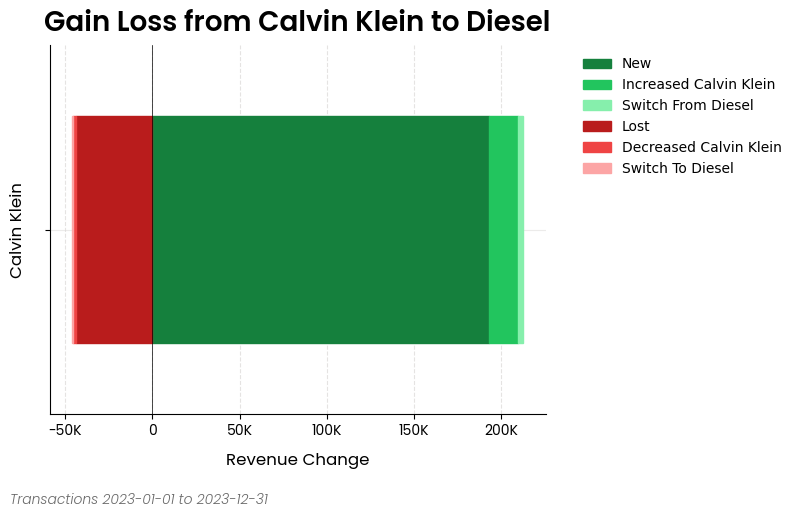

In [ ]:
from pyretailscience.analysis.gain_loss import GainLoss

gl = GainLoss(
    df,
    # Flag the rows of period 1
    p1_index=time_period_1,
    # Flag the rows of period 2
    p2_index=time_period_2,
    # Flag which rows are part of the focus group. Namely, which rows are Calvin Klein sales
    focus_group_index=df["brand_name"] == "Calvin Klein",
    focus_group_name="Calvin Klein",
    # Flag which rows are part of the comparison group. Namely, which rows are Diesel sales
    comparison_group_index=df["brand_name"] == "Diesel",
    comparison_group_name="Diesel",
    # Finally we specifiy that we want to calculate the gain/loss in total revenue
    value_col="unit_spend",
)
gl.plot(
    x_label="Revenue Change",
    source_text="Transactions 2023-01-01 to 2023-12-31",
    move_legend_outside=True,
)
plt.show()

While we can see from the above chart that the majority of new revenue came from new customers, it appears that the 
revenue increase for the period came from canabalizing Diesel sales.

If we want the raw figures on a customer or total level we can access the dataframe `gain_loss_df` and 
`gain_loss_tabel_df` respectively.

In [ ]:
display(gl.gain_loss_df)
display(gl.gain_loss_table_df)

,focus_p1,comparison_p1,total_p1,focus_p2,comparison_p2,total_p2,focus_diff,comparison_diff,total_diff,new,lost,increased_focus,decreased_focus,switch_from_comparison,switch_to_comparison
customer_id,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,36.8,0.0,36.8,36.8,0.0,36.8,36.8,0.0,0.0,0.0,0.0,0.0
4,24.0,0.0,24.0,0.0,0.0,0.0,-24.0,0.0,-24.0,0.0,-24.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,672.0,0.0,672.0,672.0,0.0,672.0,672.0,0.0,0.0,0.0,0.0,0.0
9,0.0,840.0,840.0,0.0,0.0,0.0,0.0,-840.0,-840.0,0.0,-0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,585.0,585.0,0.0,585.0,585.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4143,0.0,0.0,0.0,441.6,0.0,441.6,441.6,0.0,441.6,441.6,0.0,0.0,0.0,0.0,0.0
4187,0.0,0.0,0.0,22.4,0.0,22.4,22.4,0.0,22.4,22.4,0.0,0.0,0.0,0.0,0.0
4200,0.0,0.0,0.0,14976.0,0.0,14976.0,14976.0,0.0,14976.0,14976.0,0.0,0.0,0.0,0.0,0.0


,focus_p1,comparison_p1,total_p1,focus_p2,comparison_p2,total_p2,focus_diff,comparison_diff,total_diff,new,lost,increased_focus,decreased_focus,switch_from_comparison,switch_to_comparison
,50027.91,59885.0,109912.91,216468.824,12820.0,229288.824,166440.914,-47065.0,119375.914,192840.944,-43846.51,16630.224,-1820.436,3010.692,-374.0


We can see a breakdown of the sales by another column using the `group_col` parameter. In this case, let's say that 
we're interested in seeing how the promotion did by store. In this case, store 1 seemed to see the largest 
canabalization effect.

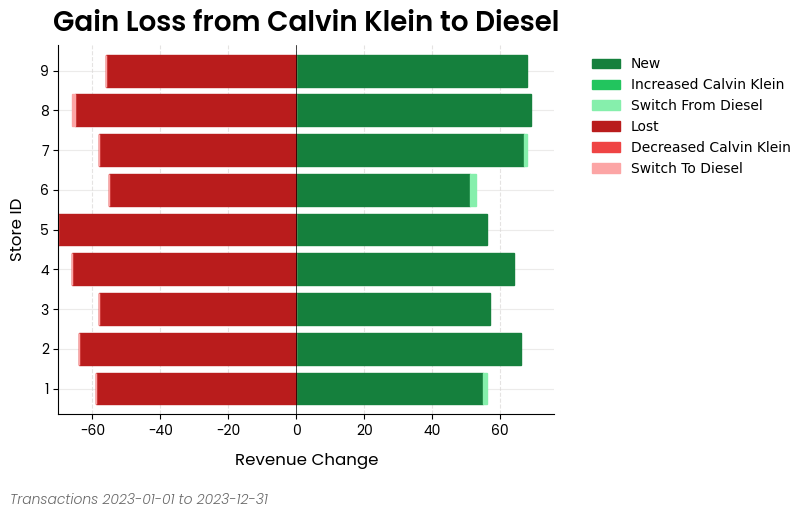

In [ ]:
gl = GainLoss(
    df,
    p1_index=time_period_1,
    p2_index=time_period_2,
    focus_group_index=df["brand_name"] == "Calvin Klein",
    focus_group_name="Calvin Klein",
    comparison_group_index=df["brand_name"] == "Diesel",
    comparison_group_name="Diesel",
    group_col="store_id",
    value_col="customer_id",
    agg_func="nunique",
)

gl.plot(
    x_label="Revenue Change",
    y_label="Store ID",
    source_text="Transactions 2023-01-01 to 2023-12-31",
    move_legend_outside=True,
)
plt.show()

We can also see the effect of the promotion by on the number of customers by changing the `value_col` parameter to 
customer_id and `agg_func` to nunqiue. This tells the code to count the number of unique customer IDs for each group.

From this view it's clear that the promotion wasn't able to grow the number of customers to the brand in the second 
half of the year.

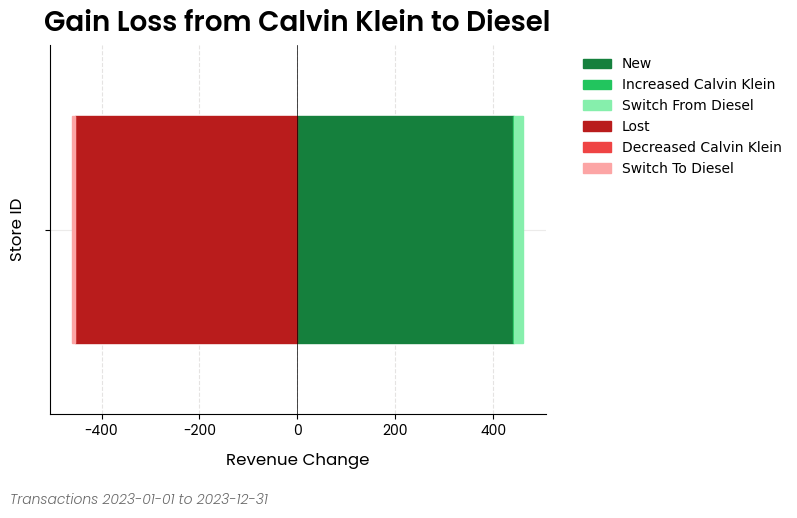

In [ ]:
gl = GainLoss(
    df,
    p1_index=time_period_1,
    p2_index=time_period_2,
    focus_group_index=df["brand_name"] == "Calvin Klein",
    focus_group_name="Calvin Klein",
    comparison_group_index=df["brand_name"] == "Diesel",
    comparison_group_name="Diesel",
    value_col="customer_id",
    agg_func="nunique",
)
gl.plot(
    x_label="Revenue Change",
    y_label="Store ID",
    source_text="Transactions 2023-01-01 to 2023-12-31",
    move_legend_outside=True,
)
plt.show()

### Follow on on analysis

Gain/loss analysis only forms part of a review. As follow on analysis you may want to ask questions such as,

* Did the lost customers make any other purchases in the store? Or did they churn entirely?
* Did buyers of the promotion spend more in the store overall?
* Did Diesel brand purchases decrease in H2, negating or offsetting the canbalization?
